In [1]:
import os
os.chdir('../')

import DeepPurpose.CompoundPred as property_pred
from DeepPurpose.utils import *
from DeepPurpose.dataset import *

from sklearn.metrics import mean_squared_error, roc_auc_score, average_precision_score, f1_score


import numpy as np

from ax.plot.contour import interact_contour, plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.utils.tutorials.cnn_utils import load_mnist, train, evaluate, CNN


import warnings
warnings.filterwarnings("ignore")

init_notebook_plotting()

[INFO 05-10 14:48:43] ipy_plotting: Injecting Plotly library into cell. Do not overwrite or delete cell.


In [2]:
fold_n = 1
balanced = True
train = pd.read_csv('./aicures_data/train_cv/fold_'+str(fold_n)+'/train.csv')
dev = pd.read_csv('./aicures_data/train_cv/fold_'+str(fold_n)+'/dev.csv')
test = pd.read_csv('./aicures_data/train_cv/fold_'+str(fold_n)+'/test.csv')

if balanced:
    # oversample balanced training
    train = pd.concat([train[train.activity == 1].sample(n = len(train[train.activity == 0]), replace=True), train[train.activity == 0]]).sample(frac = 1).reset_index(drop = True)

X_train = train.smiles.values
y_train = train.activity.values
X_dev = dev.smiles.values
y_dev = dev.activity.values
X_test = test.smiles.values
y_test = test.activity.values

drug_encoding = 'Morgan'
train = data_process(X_drug = X_train, y = y_train, 
                                drug_encoding = drug_encoding,
                                split_method='no_split', 
                                random_seed = 1)

val = data_process(X_drug = X_dev, y = y_dev, 
                                drug_encoding = drug_encoding,
                                split_method='no_split', 
                                random_seed = 1)

test = data_process(X_drug = X_test, y = y_test, 
                                drug_encoding = drug_encoding,
                                split_method='no_split', 
                                random_seed = 1)

Drug Property Prediction Mode...
in total: 3328 drugs
encoding drug...
unique drugs: 1694
drug encoding finished...
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 201 drugs
encoding drug...
unique drugs: 201
drug encoding finished...
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 202 drugs
encoding drug...
unique drugs: 202
drug encoding finished...
do not do train/test split on the data for already splitted data


In [3]:
def run_Morgan(parameterization):    
    config = generate_config(drug_encoding = drug_encoding, 
                         cls_hidden_dims = [parameterization['cls_hidden_dims']], 
                         train_epoch = 10, 
                         LR = parameterization['LR'], 
                         batch_size = parameterization['batch_size'],
                         decay = parameterization['decay']
                        )
    
    model = property_pred.model_initialize(**config)
    model.train(train, val, test, verbose = False)
    
    scores = model.predict(test, verbose = False)
    return average_precision_score(test.Label.values, scores)

In [4]:
# easy tuning 

In [5]:
best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "LR", "type": "range", "bounds": [1e-6, 1e-3], "log_scale": False},
        {"name": "decay", "type": "range", "bounds": [0.0, 0.2], "log_scale": False},
        {"name": "cls_hidden_dims", "type": "choice", "values": [32, 64, 128, 256, 512]},
        {"name": "batch_size", "type": "choice", "values": [64, 128, 256]}
    ],
    evaluation_function=run_Morgan,
    objective_name='accuracy',
)

[INFO 05-10 14:48:44] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 05-10 14:48:44] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 05-10 14:48:44] ax.service.managed_loop: Running optimization trial 1...
[INFO 05-10 14:48:57] ax.service.managed_loop: Running optimization trial 2...
[INFO 05-10 14:49:08] ax.service.managed_loop: Running optimization trial 3...
[INFO 05-10 14:49:24] ax.service.managed_loop: Running optimization trial 4...
[INFO 05-10 14:49:35] ax.service.managed_loop: Running optimization trial 5...
[INFO 05-10 14:49:47] ax.service.managed_loop: Running optimization trial 6...
[INFO 05-10 14:50:01] ax.service.managed_loop: Running optimization trial 7...
[INFO 05-10 14:50:20] ax.service.managed_loop: Running optimization trial 8...
[INFO 05-10 14:50:32] ax.service.managed_loop: Running optimization trial 9...
[INFO 05-10 14:50:46] ax.service.managed_loop: Running optimization trial 10...
[INFO 05-10 14:51:00] ax.service.ma

In [6]:
best_parameters

{'LR': 0.00017391057281102986,
 'decay': 0.13253133054822683,
 'cls_hidden_dims': 256,
 'batch_size': 128}

In [7]:
means, covariances = values
means, covariances

({'accuracy': 0.567285785786404}, {'accuracy': {'accuracy': 0.0}})

In [8]:
best_objectives = np.array([[trial.objective_mean*100 for trial in experiment.trials.values()]])
best_objective_plot = optimization_trace_single_method(
    y=np.maximum.accumulate(best_objectives, axis=1),
    title="Model performance vs. # of iterations",
    ylabel="Classification Accuracy, %",
)
render(best_objective_plot)

In [9]:
# for more customized optimization and plotting

In [10]:
import os
import json
import numpy as np
import argparse
import datetime
from ax import ParameterType, ChoiceParameter, RangeParameter, FixedParameter, SearchSpace, SimpleExperiment, modelbridge, models
from ax.plot.contour import interact_contour, plot_contour
from ax.plot.diagnostic import interact_cross_validation
from ax.plot.scatter import interact_fitted, plot_objective_vs_constraints
from ax.plot.slice import plot_slice
from ax.modelbridge.cross_validation import cross_validate
from ax.plot.trace import optimization_trace_single_method
from plotly.offline import plot

In [11]:
opt_trials = 16
init_trials = 5
dset = 'Morgan'

# Search space
search_space = SearchSpace(parameters=[
    RangeParameter(
        name='LR', parameter_type=ParameterType.FLOAT, 
        lower=1e-6, upper=1e-3, log_scale=False),
    RangeParameter(
        name='decay', parameter_type=ParameterType.FLOAT, 
        lower=0, upper=0.2, log_scale=False),
    ChoiceParameter(
        name='batch_size', parameter_type=ParameterType.INT, 
        values=[64, 128, 256]), 
    ChoiceParameter(
        name='cls_hidden_dims', parameter_type=ParameterType.INT, 
        values=[64, 128, 256, 512]), 
])

# Create Experiment
exp = SimpleExperiment(
    name = 'Morgan',
    search_space = search_space,
    evaluation_function = run_Morgan,
    objective_name = 'accuracy',
)

# Run the optimization and fit a GP on all data
sobol = modelbridge.get_sobol(search_space=exp.search_space)
print(f"\nRunning Sobol initialization trials...\n{'='*40}\n")
for _ in range(init_trials):
    exp.new_trial(generator_run=sobol.gen(1))

for i in range(opt_trials):
    print(f"\nRunning GP+EI optimization trial {i+1}/{opt_trials}...\n{'='*40}\n")
    gpei = modelbridge.get_GPEI(experiment=exp, data=exp.eval())
    exp.new_trial(generator_run=gpei.gen(1))


Running Sobol initialization trials...


Running GP+EI optimization trial 1/16...


Running GP+EI optimization trial 2/16...


Running GP+EI optimization trial 3/16...


Running GP+EI optimization trial 4/16...


Running GP+EI optimization trial 5/16...


Running GP+EI optimization trial 6/16...


Running GP+EI optimization trial 7/16...


Running GP+EI optimization trial 8/16...


Running GP+EI optimization trial 9/16...


Running GP+EI optimization trial 10/16...


Running GP+EI optimization trial 11/16...


Running GP+EI optimization trial 12/16...


Running GP+EI optimization trial 13/16...


Running GP+EI optimization trial 14/16...


Running GP+EI optimization trial 15/16...


Running GP+EI optimization trial 16/16...



In [ ]:
# each plot will be opened in a html tab 

In [12]:
output_dir = os.path.join('Ax_output', dset, datetime.datetime.now().strftime('%m%d-%H%M%S'))
os.makedirs(output_dir)

# Save all experiment parameters 
df = exp.eval().df
df.to_csv(os.path.join(output_dir, 'exp_eval.csv'), index=False)

# Save best parameter
best_arm_name = df.arm_name[df['mean'] == df['mean'].max()].values[0]
exp_arm = {k:v.parameters for k, v in exp.arms_by_name.items()}
exp_arm['best'] = best_arm_name
print('Best arm:\n', str(exp.arms_by_name[best_arm_name]))
with open(os.path.join(output_dir, 'exp_arm.json'), 'w') as f: 
    json.dump(exp_arm, f)

# Contour Plot
os.makedirs(os.path.join(output_dir, 'contour_plot'))
for metric in ['accuracy']:
    contour_plot = interact_contour(model=gpei, metric_name=metric)
    plot(contour_plot.data, filename=os.path.join(output_dir, 'contour_plot', '{}.html'.format(metric)))

# Slice Plot
# show the metric outcome as a function of one parameter while fixing the others
os.makedirs(os.path.join(output_dir, 'slice_plot'))
for param in ["LR", "decay"]:
    slice_plot = plot_slice(gpei, param, "accuracy")
    plot(slice_plot.data, filename=os.path.join(output_dir, 'slice_plot', '{}.html'.format(param)))

# Tile Plot
# the effect of each arm
tile_plot = interact_fitted(gpei, rel=False)
plot(tile_plot.data, filename=os.path.join(output_dir, 'tile_plot.html'))

# Cross Validation plot
# splits the model's train data into train/test folds and makes out-of-sample predictions on the test folds.
cv_results = cross_validate(gpei)
cv_plot = interact_cross_validation(cv_results)
plot(cv_plot.data, filename=os.path.join(output_dir, 'cv_plot.html'))


Best arm:
 Arm(name='16_0', parameters={'LR': 0.00043294545493323936, 'decay': 0.08204705377971983, 'batch_size': 64, 'cls_hidden_dims': 256})


'Ax_output/Morgan/0510-145936/cv_plot.html'

In [13]:
# use the selected parameter.

In [16]:
def run_Morgan(fold_n, balanced, parameterization):
    
    train = pd.read_csv('./aicures_data/train_cv/fold_'+str(fold_n)+'/train.csv')
    dev = pd.read_csv('./aicures_data/train_cv/fold_'+str(fold_n)+'/dev.csv')
    test = pd.read_csv('./aicures_data/train_cv/fold_'+str(fold_n)+'/test.csv')
    
    if balanced:
        # oversample balanced training
        train = pd.concat([train[train.activity == 1].sample(n = len(train[train.activity == 0]), replace=True), train[train.activity == 0]]).sample(frac = 1).reset_index(drop = True)
    
    X_train = train.smiles.values
    y_train = train.activity.values
    X_dev = dev.smiles.values
    y_dev = dev.activity.values
    X_test = test.smiles.values
    y_test = test.activity.values
    
    drug_encoding = 'Morgan'
    train = data_process(X_drug = X_train, y = y_train, 
                                    drug_encoding = drug_encoding,
                                    split_method='no_split', 
                                    random_seed = 1)

    val = data_process(X_drug = X_dev, y = y_dev, 
                                    drug_encoding = drug_encoding,
                                    split_method='no_split', 
                                    random_seed = 1)

    test = data_process(X_drug = X_test, y = y_test, 
                                    drug_encoding = drug_encoding,
                                    split_method='no_split', 
                                    random_seed = 1)
    
    config = generate_config(drug_encoding = drug_encoding, 
                         cls_hidden_dims = [parameterization['cls_hidden_dims']], 
                         train_epoch = 10, 
                         LR = parameterization['LR'], 
                         batch_size = parameterization['batch_size'],
                         decay = parameterization['decay']
                        )
    
    model = property_pred.model_initialize(**config)
    model.train(train, val, test)
    
    scores = model.predict(test)
    
    return roc_auc_score(test.Label.values, scores), average_precision_score(test.Label.values, scores), scores, test.Label.values

Drug Property Prediction Mode...
in total: 3328 drugs
encoding drug...
unique drugs: 1694
drug encoding finished...
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 201 drugs
encoding drug...
unique drugs: 201
drug encoding finished...
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 202 drugs
encoding drug...
unique drugs: 202
drug encoding finished...
do not do train/test split on the data for already splitted data
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69255. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.79187 , AUPRC: 0.53684 , F1: 0.36363
Training at Epoch 2 iteration 0 with loss 0.55604. Total time 0.00027 hours
Validation at Epoch 2 , AUROC: 0.78553 , AUPRC: 0.53354 , F1: 0.57142
Training at Epoch 3 iteration 0 with loss 0.02210. Total time 0.00055 hours
Validation at Epoch 3 , AUROC: 

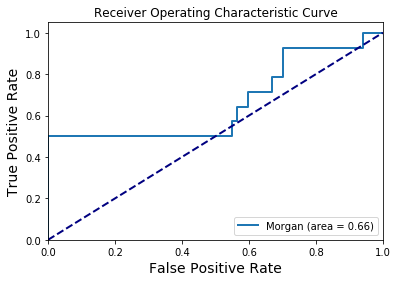

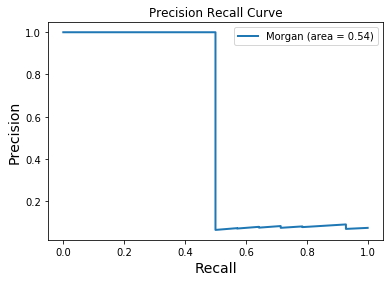

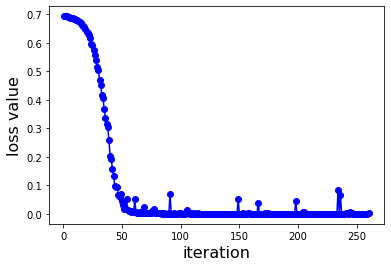

In [19]:
roc, prc, scores, labels = run_Morgan(1, True, best_parameters)

In [ ]:
# We thank Chih-Ying Deng and Ax tutorials for the scripts on BO.